In [1]:
from transformers import BertConfig, ViTConfig, VisionEncoderDecoderConfig, VisionEncoderDecoderModel
import requests
from PIL import Image

from transformers import GPT2TokenizerFast, ViTImageProcessor, VisionEncoderDecoderModel
from transformers import ViTImageProcessor, BertTokenizer, VisionEncoderDecoderModel
from datasets import load_dataset

import pandas as pd
from datasets import Dataset, DatasetDict

from tqdm.auto import tqdm
from datasets import Dataset
import numpy as np
import torch
from transformers import VisionEncoderDecoderModel, AutoTokenizer, AutoFeatureExtractor
from transformers import TrainingArguments
from transformers import Trainer



## Convert my customerized dataset to HuggingFace's dataset format

In [2]:
df = pd.read_csv("fine_tuning_dataset/instagram_data2/captions_csv2.csv",  names=["id", "image_path", "caption"],nrows=20)
dataset = Dataset.from_pandas(df[['caption', 'image_path']])

from PIL import Image
def load_image_with_caption(example):
    image_path = f"fine_tuning_dataset/instagram_data2/{example['image_path']}.jpg"
    return {'image': Image.open(image_path).convert("RGB"), 'caption': example['caption']}

# Map the function over the dataset
dataset = dataset.map(load_image_with_caption, batched=False)

/Users/stoneman/anaconda3/lib/python3.11/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [3]:
# Remove the image_path feature
dataset = dataset.remove_columns(['image_path'])

print(dataset)
print(dataset[0])

Dataset({
    features: ['caption', 'image'],
    num_rows: 20
})
{'caption': 'wHaT dAy Is It Even #stayhomeclub', 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1080x1350 at 0x11152A810>}


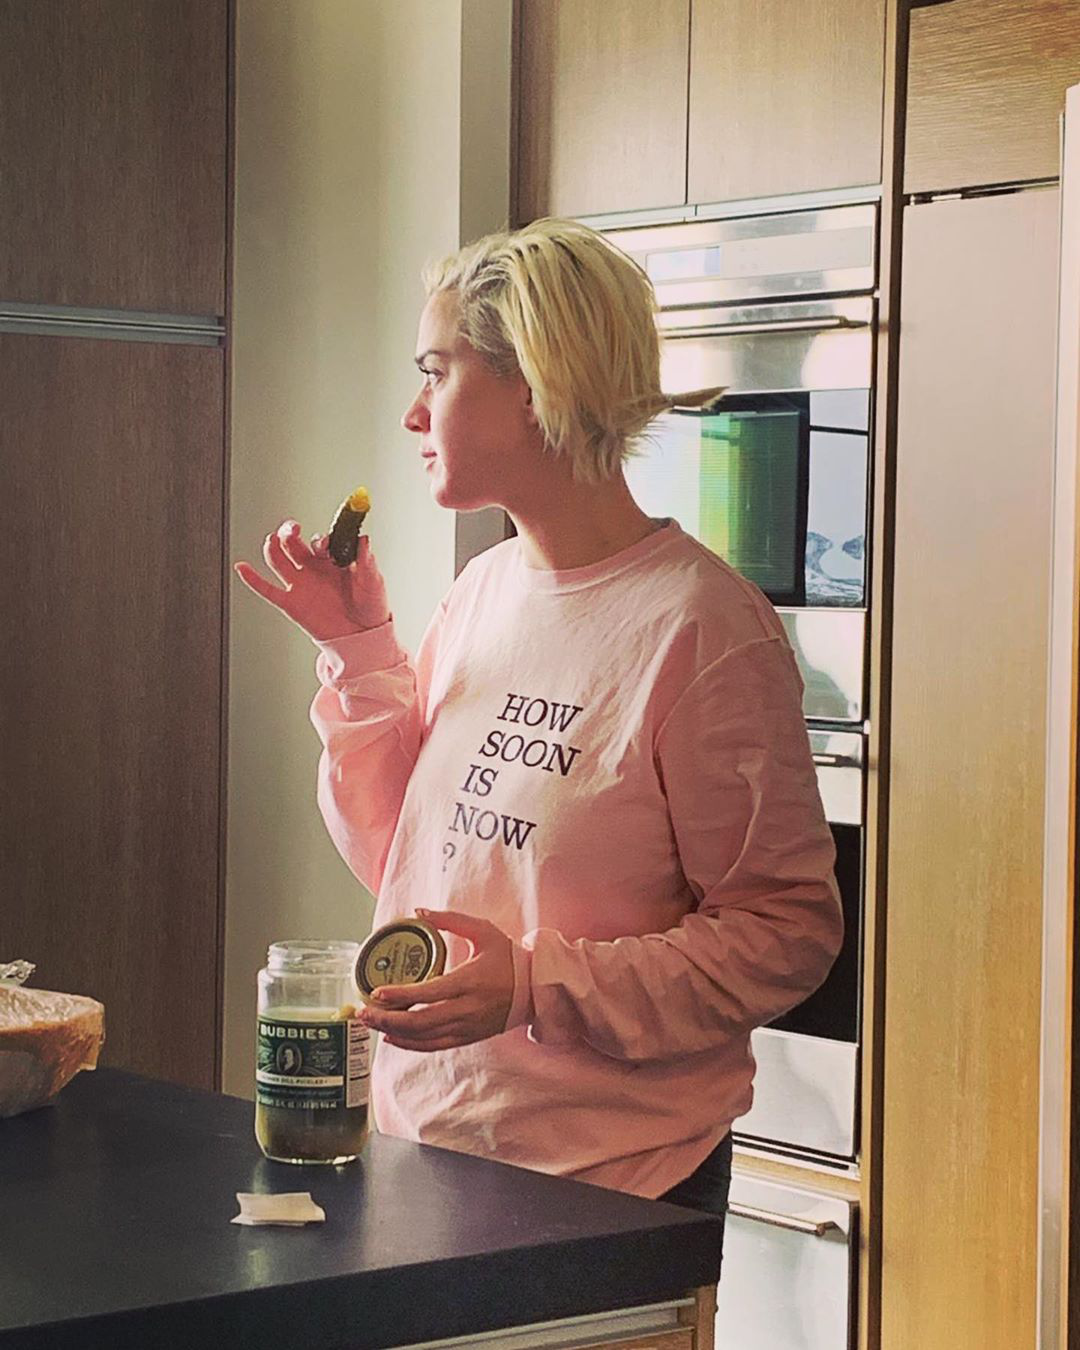

In [4]:
dataset[0]['image']

## Build the model from a pretrained model

In [ ]:
# config_encoder = ViTConfig()
# config_decoder = BertConfig()

# config = VisionEncoderDecoderConfig.from_encoder_decoder_configs(config_encoder, config_decoder)
# model = VisionEncoderDecoderModel(config=config)

In [ ]:

# image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
#     "google/vit-base-patch16-224-in21k", "bert-base-uncased"
# )

# model.config.decoder_start_token_id = tokenizer.cls_token_id
# model.config.pad_token_id = tokenizer.pad_token_id


In [5]:
# load a fine-tuned image captioning model and corresponding tokenizer and image processor
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = GPT2TokenizerFast.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
image_processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

In [29]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')

239,195,904 total parameters.


In [31]:
print(torch.has_mps)
# Check if GPU is available and set the device accordingly
device = torch.device("mps") if torch.has_mps else torch.device("cpu")  # mps is for Apple Silicon GPU

True


/var/folders/qx/wt3y86vj50sg2s6pkc5y62l00000gn/T/ipykernel_60122/3385973513.py:1: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  print(torch.has_mps)
/var/folders/qx/wt3y86vj50sg2s6pkc5y62l00000gn/T/ipykernel_60122/3385973513.py:3: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps") if torch.has_mps else torch.device("cpu")  # mps is for Apple Silicon GPU


In [33]:
# Move the model to the GPU
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [60]:
image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

## Perform inference on a sample image

In [15]:
pixel_values = image_processor(dataset[0]['image'], return_tensors="pt").pixel_values

# autoregressively generate caption (uses greedy decoding by default)
generated_ids = model.generate(pixel_values)
generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

a woman eating a sandwich in a kitchen 


In [26]:
# try on my own local image
image_path = "DSC01066.JPG"
image = Image.open(image_path)

# Process the image with the image processor
pixel_values = image_processor(image, return_tensors="pt").pixel_values

generated_ids = model.generate(pixel_values)
generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

/Users/stoneman/anaconda3/lib/python3.11/site-packages/transformers/generation/utils.py:1254: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a woman with a mask on holding a large knife 


In [20]:
pixel_values.shape

torch.Size([1, 3, 224, 224])

## Split the dataset into train, and test sets

In [15]:

# Split the dataset into train and test
train_test_split = dataset.train_test_split(test_size=0.2)

# Create a DatasetDict
dataset_dict = DatasetDict({
    "train": train_test_split["train"],
    "test": train_test_split["test"]
})


In [16]:
train_test_split

DatasetDict({
    train: Dataset({
        features: ['caption', 'image'],
        num_rows: 16
    })
    test: Dataset({
        features: ['caption', 'image'],
        num_rows: 4
    })
})

## Fine-tune the model

In [24]:
print(tokenizer)

GPT2TokenizerFast(name_or_path='nlpconnect/vit-gpt2-image-captioning', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True)


In [141]:
# load a fine-tuned image captioning model and corresponding tokenizer and image processor
# model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
# tokenizer = GPT2TokenizerFast.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
# image_processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")


bos_token_id = tokenizer.convert_tokens_to_ids('<|endoftext|>')
pad_token_id = tokenizer.convert_tokens_to_ids('<|endoftext|>')  # If you really need to set it

model.config.decoder_start_token_id = bos_token_id
model.config.pad_token_id = pad_token_id


captions = tokenizer(
    dataset["caption"][0],
    return_tensors="pt"
).input_ids

pixel_values = image_processor(dataset[0]["image"], return_tensors="pt").pixel_values

# the forward function automatically creates the correct decoder_input_ids
loss = model(pixel_values=pixel_values, labels=captions).loss
loss

tensor(7.5890, grad_fn=<NllLossBackward0>)

In [72]:
loss.backward()

In [45]:
print(model)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [63]:
# Freeze all parameters first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last four layers
# Assuming the last four layers are in the decoder
layers_to_unfreeze = [240,241, 242, 243]  # indices of the last four layers
for i, param in enumerate(model.decoder.parameters()):
    if i in layers_to_unfreeze:
        param.requires_grad = True


In [80]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_trainable_params

2361600

In [76]:
train_test_split["train"]

Dataset({
    features: ['caption', 'image'],
    num_rows: 16
})

In [105]:
training_args = TrainingArguments(
  output_dir="fine_tuned_model",
  per_device_train_batch_size=1,
  evaluation_strategy="steps",
  num_train_epochs=2,
  save_steps=100,
  eval_steps=100,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
  disable_tqdm=False
)

trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=train_test_split["train"],
  eval_dataset=train_test_split["test"],
  tokenizer=tokenizer
)



Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

In [8]:
def preprocess_data(example):
  # Process image
  pixel_values = image_processor(example["image"], return_tensors="pt").pixel_values
  # Encode caption
  encoding = tokenizer(example["caption"], padding=True, truncation=True, max_length=128, return_tensors="pt")
  return {"pixel_values": pixel_values, "labels": encoding.input_ids}

train_dataset = train_test_split["train"].map(preprocess_data, batched=True, remove_columns=['caption', 'image'])
eval_dataset = train_test_split["test"].map(preprocess_data, batched=True, remove_columns=['caption', 'image'])


# Update the Trainer with the preprocessed datasets
trainer.train_dataset = train_dataset
trainer.eval_dataset = eval_dataset

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

NameError: name 'image_processor' is not defined

# STUCK HERE!!!

In [134]:

# Now, try training
train_results = trainer.train()

  0%|          | 0/32 [00:00<?, ?it/s]

ValueError: You should supply an encoding or a list of encodings to this method that includes input_ids, but you provided ['pixel_values', 'labels']

In [113]:
trainer.train_dataset

Dataset({
    features: ['labels', 'input_ids'],
    num_rows: 16
})

In [101]:
trainer.train_dataset

Dataset({
    features: ['caption', 'image'],
    num_rows: 16
})

In [ ]:

trainer.save_model()
trainer.save_state()


# Try 
## image_encoder_model = "google/vit-base-patch16-224-in21k"
## text_decode_model = "gpt2"

References:
- https://ankur3107.github.io/blogs/the-illustrated-image-captioning-using-transformers/

In [9]:
image_encoder_model = "google/vit-base-patch16-224-in21k"
text_decode_model = "gpt2"

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    image_encoder_model, text_decode_model)

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.3.ln_cross_attn.weight', 'h.8.crossattention.c_proj.bias', 'h.2.ln_cross_attn.weight', 'h.2.crossattention.c_attn.weight', 'h.9.ln_cross_attn.weight', 'h.8.ln_cross_attn.bias', 'h.6.ln_cross_attn.weight', 'h.0.crossattention.q_attn.bias', 'h.3.crossattention.c_proj.weight', 'h.1.crossattention.c_attn.weight', 'h.6.crossattention.c_attn.weight', 'h.11.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.3.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.bias', 'h.4.crossattention.c_attn.weight', 'h.2.crossattention.q_attn.bias', 'h.2.crossattention.c_attn.bias', 'h.2.ln_cross_attn.bias', 'h.6.crossattention.q_attn.weight', 'h.0.crossattention.c_proj.weight', 'h.8.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.weight', 'h.7.crossattention.c_attn.weight', 'h.0.crossattention.c_attn.weight', 'h.7.crossattention.q_attn.weight', 'h.5.crossat

In [10]:
# image feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained(image_encoder_model)
# text tokenizer
tokenizer = AutoTokenizer.from_pretrained(text_decode_model)

/Users/stoneman/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [11]:
# GPT2 only has bos/eos tokens but not decoder_start/pad tokens
tokenizer.pad_token = tokenizer.eos_token

# update the model config
model.config.eos_token_id = tokenizer.eos_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

In [132]:
output_dir = "fine-tuned-encoder-decoder-model"
model.save_pretrained(output_dir)
feature_extractor.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('fine-tuned-encoder-decoder-model/tokenizer_config.json',
 'fine-tuned-encoder-decoder-model/special_tokens_map.json',
 'fine-tuned-encoder-decoder-model/vocab.json',
 'fine-tuned-encoder-decoder-model/merges.txt',
 'fine-tuned-encoder-decoder-model/added_tokens.json',
 'fine-tuned-encoder-decoder-model/tokenizer.json')

In [ ]:
import datasets
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/zips/test2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!wget http://images.cocodataset.org/annotations/image_info_test2017.zip 

COCO_DIR = '/Users/stoneman/Library/CloudStorage/OneDrive-Vanderbilt/Transformers/Transformers/Final-Project-Automatic-IG-Caption-Generator'
ds = datasets.load_dataset("ydshieh/coco_dataset_script", "2017", data_dir=COCO_DIR)

In [13]:
# text preprocessing step
def tokenization_fn(captions):
    """Run tokenization on captions."""
    labels = tokenizer(captions, 
                      padding="max_length", 
                      max_length=128).input_ids

    return labels

# image preprocessing step
def feature_extraction_fn(image):
    """
    Run feature extraction on images
    If `check_image` is `True`, the examples that fails during `Image.open()` will be caught and discarded.
    Otherwise, an exception will be thrown.
    """

    encoder_inputs = feature_extractor(image, return_tensors="np")
    return encoder_inputs.pixel_values

def preprocess_fn(examples):
    """Run tokenization + image feature extraction"""
    image = examples['image']
    caption = examples['caption']    

    
    model_inputs = {}
    # This contains image path column
    model_inputs['labels'] = tokenization_fn(caption)
    model_inputs['pixel_values'] = feature_extraction_fn(image)

    return model_inputs

In [32]:
processed_dataset = {}
processed_dataset['train'] = train_test_split['train'].map(
    function=preprocess_fn,
    batched=True,
    remove_columns=train_test_split['train'].column_names
)
processed_dataset['test'] = train_test_split['test'].map(
    function=preprocess_fn,
    batched=True,
    remove_columns=train_test_split['train'].column_names
)

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

In [33]:
processed_dataset

{'train': Dataset({
     features: ['labels', 'pixel_values'],
     num_rows: 16
 }),
 'test': Dataset({
     features: ['labels', 'pixel_values'],
     num_rows: 4
 })}

In [30]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    output_dir="./image-captioning-output",
)

In [ ]:
# import numpy as np

# ignore_pad_token_for_loss = True


# def postprocess_text(preds, labels):
#     preds = [pred.strip() for pred in preds]
#     labels = [label.strip() for label in labels]

#     # rougeLSum expects newline after each sentence
#     preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
#     labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

#     return preds, labels


# def compute_metrics(eval_preds):
#     preds, labels = eval_preds
#     if isinstance(preds, tuple):
#         preds = preds[0]
#     decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
#     if ignore_pad_token_for_loss:
#         # Replace -100 in the labels as we can't decode them.
#         labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
#     decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

#     # Some simple post-processing
#     decoded_preds, decoded_labels = postprocess_text(decoded_preds,
#                                                      decoded_labels)

#     result = metric.compute(predictions=decoded_preds,
#                             references=decoded_labels,
#                             use_stemmer=True)
#     result = {k: round(v * 100, 4) for k, v in result.items()}
#     prediction_lens = [
#         np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds
#     ]
#     result["gen_len"] = np.mean(prediction_lens)
#     return result

In [34]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=feature_extractor,
    args=training_args,
    train_dataset=processed_dataset['train'],
    eval_dataset=processed_dataset['test'],
    data_collator=default_data_collator,
)

In [35]:
trainer.train()

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.8136133551597595, 'eval_runtime': 0.3973, 'eval_samples_per_second': 10.067, 'eval_steps_per_second': 2.517, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7683776021003723, 'eval_runtime': 0.431, 'eval_samples_per_second': 9.28, 'eval_steps_per_second': 2.32, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7611636519432068, 'eval_runtime': 0.3978, 'eval_samples_per_second': 10.055, 'eval_steps_per_second': 2.514, 'epoch': 3.0}
{'train_runtime': 19.8481, 'train_samples_per_second': 2.418, 'train_steps_per_second': 0.605, 'train_loss': 2.3011743227640786, 'epoch': 3.0}


TrainOutput(global_step=12, training_loss=2.3011743227640786, metrics={'train_runtime': 19.8481, 'train_samples_per_second': 2.418, 'train_steps_per_second': 0.605, 'train_loss': 2.3011743227640786, 'epoch': 3.0})